# Denoising Diffusion Probabilistic Models (DDPM)

This notebook is an implementation of the DDPM model proposed in the article by Ho et al. [1].

In [7]:
# Python imports
import random
import math
import abc
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

## 0. Constants

In [8]:
# Hyper-parameters.
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 1
GROUP_NORM_GROUPS = 32

# Diffusion model parameters.
TIMESTAMPS = 1000

# Dataset parameters.
WIDTH = 32
HEIGHT = 32
WIDTH_ORI = 28
HEIGHT_ORI = 28
CHANNELS = 1

# Others
SAVED_FILENAME = 'MNIST'

Decide which device to run the model.

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Print the device to run the model.
print(f"Using {DEVICE} device")

Using cuda device


## 1. Dataset

Let's use CelebA as our dataset.

In [10]:
# Each item in dataset is a tuple of (torch.Tensor, int).
# The first tensor is of shape (CHANNELS, HEIGHT, WIDTH) and dtype torch.float32, which is the image.
dataset = utils.MNIST(
    './data',
    train=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((HEIGHT, WIDTH))]),
)

c:\Users\shuan\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Create a dataloader for the dataset.

In [11]:
# samples = next(iter(dataloader))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, 1, WIDTH, HEIGHT)
# samples[1] is a tensor of shape (BATCH_SIZE, 40)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Print out the statistics of the dataset.

In [12]:
# Get the size of the dataset.
dataset_size = len(dataset)

# Construct data structures used by tabulate.
headers = ['Property', 'Value']
rows = [
    ['Size', dataset_size],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Property   |   Value |
|------------|---------|
| Size       |   60000 |


Show some samples from the dataset.

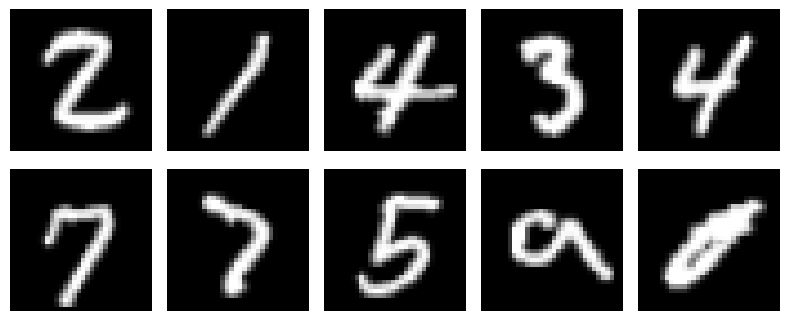

In [13]:
# Sample 10 unique indices from the index range of the dataset.
indices = random.sample(range(dataset_size), k=10)

rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(8, 3.5))
for i in range(len(indices)):
    row = i // cols
    col = i % cols
    axs[row][col].imshow(dataset[indices[i]][0].permute(1, 2, 0), cmap=plt.cm.gray)
    axs[row][col].axis('off')
plt.tight_layout()

## 2. Forward Diffusion

In [14]:
class Diffusion:

    def __init__(self, timestamps_max):

        self.timestamps_max = timestamps_max

        self._calculateAlphas()

    def _linear_beta_schedule(self, timestamps):
        r"""Generate betas for adding noise to images in a linear way.

        The returned value is a tensor of shape (timestamps,) and dtype torch.float32.
        """

        scale = 1000 / timestamps
        beta_start_scaled = 0.0001 * scale
        beta_end_scaled = 0.02 * scale
        return torch.linspace(start=beta_start_scaled, end=beta_end_scaled, steps=timestamps, device=DEVICE)
    
    def _calculateAlphas(self):
        """Calculate the variables related to alphas."""

        # self.betas is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.betas = self._linear_beta_schedule(self.timestamps_max)
        # self.alphas is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.alphas = 1 - self.betas
        # self.alphas_cumprod is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.alphas_cumprod = self.alphas.cumprod(dim=0)
        # self.sqrt_alphas_cumprod is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        # self.sqrt_one_minum_alphas_cumprod is a tensor of shape (self.timestamps_max,) and dtype torch.float32.
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas).sqrt()

    def _constructAlphaTensor(self, src, t, num_dim):
        """Construct the alpha values or one minus alpha values for adding noise.

        Args:
            src (shape (self.timestamps_max,) & dtype torch.float32): self.sqrt_alphas_cumprod
                or self.sqrt_one_minus_alphas_cumprod.
            t (shape (BATCH_SIZE,) & dtype torch.int64): time representation.
            num_dim (int): number of dimensions in the images.
        """

        batch_size = t.size()[0]

        # alphas is a tensor of shape (batch_size,) and torch.float32.
        alphas = src.gather(dim=0, index=t)

        # Return a tensor of shape (batch_size, 1, 1, 1) and torch.float32.
        return alphas.reshape(batch_size, *((1,) * (num_dim-1)))

    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion.

        Args:
            x_start (shape (BATCH_SIZE, 3, HEIGHT, WIDTH) & dtype torch.float32): images to diffuse.
            t (shape (BATCH_SIZE,) & dtype torch.float32): time representation.
        """

        # Generate the noise.
        # noise is a tensor of shape (BATCH_SIZE, 3, HEIGHT, WIDTH) and dtype torch.float32.
        if noise == None:
            noise = torch.randn_like(x_start)

        # Generate the alpha values and one minus alpha value for adding noise.
        # sqrt_alphas_cumprod_t is a tensor of shape (BATCH_SIZE, 1, 1, 1) and dtype torch.float32.
        sqrt_alphas_cumprod_t = self._constructAlphaTensor(self.sqrt_alphas_cumprod, t, len(x_start.shape))
        # sqrt_one_minus_alphas_cumprod_t is a tensor of shape (BATCH_SIZE, 1, 1, 1) and dtype torch.float32.
        sqrt_one_minus_cumprod_t = self._constructAlphaTensor(self.sqrt_one_minus_alphas_cumprod, t, len(x_start.shape))
        
        # Return a tensor of shape (BATCH_SIZE, 3, HEIGHT, WIDTH) and dtype torch.float32.
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_cumprod_t * noise

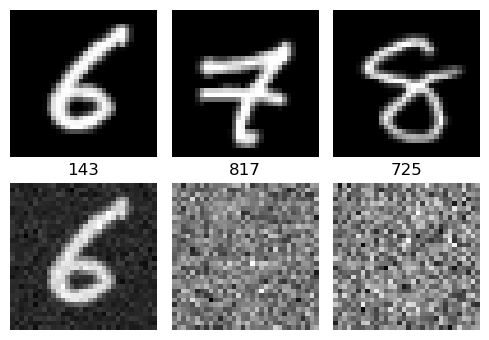

In [15]:
diffusion = Diffusion(TIMESTAMPS)

# t is a tensor of shape (BATCH_SIZE,) and dtype torch.int64.
t = torch.randint(0, TIMESTAMPS, (BATCH_SIZE,), device=DEVICE)

# Sample 5 images from the dataset.
# images is a tensor of shape (BATCH_SIZE, 3, 218, 178) and dtype torch.float32.
images = next(iter(dataloader))[0].to(DEVICE)

# Add noise to the images.
noisy_images = diffusion.q_sample(images, t)

# Show the noisy images.
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(5, 3.5))
for col in range(cols):
    axs[0][col].imshow(images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[0][col].axis('off')
for col in range(cols):
    axs[1][col].imshow(noisy_images[col].permute(1, 2, 0).cpu(), cmap=plt.cm.gray)
    axs[1][col].axis('off')
    axs[1][col].set_title(t[col].item())
plt.tight_layout()

## 3. Model

Timestamp embedding.

In [16]:
def time_embedding(t, dim, period_max=10000.):
    """Calculate embedding for timestamps.

    Args:
        t (shape (BATCH_SIZE,) & dtype torch.int64): time representation.
        dim (int): dimension of the embedding.
        period_max(float): max period of sinusoidal and cosinoidal functions.
    """

    # batch_size is a Python int.
    batch_size = t.size()[0]

    # Calculate half of the embedding dimension.
    # half is a Python float.
    half = dim // 2

    # Calculate the parameter w that controls frequencies.
    # w is a tensor of shape (half,) and dtype torch.float32.
    w = torch.exp(
        -math.log(period_max) *
        torch.arange(start=0, end=half, dtype=torch.float32, device=DEVICE) / half
    )
    
    # args is the arguments of sinusoidal and cosinoidal functions.
    # args is a tensor of shape (batch_size, half) and dtype torch.float32.
    # t[:, None] is a tensor of shape (batch_size, 1) and dtype torch.int64.
    # w[None, :] is a tensor of shape (1, half) and dtype torch.float32.
    args = t[:, None].float() * w[None, :]
    
    # embedding is a tensor of shape (batch_size, half*2) and dtype torch.float32.
    embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

    # embedding is a tensor of shape (batch_size, dim) and dtype torch.float32.
    if dim % 2 != 0:
        embedding = torch.cat([embedding, torch.zeros(batch_size, 1)], dim=-1)

    return embedding

Define a module that accepts time embedding.

In [17]:
class EmbeddingBlock(torch.nn.Module, abc.ABC):
    """Any module where forward() takes timestep embeddings as
    a second argument.
    """

    @abc.abstractmethod
    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

Define a sequential module that contains EmbeddingBlock.

In [18]:
class EmbeddingSequential(torch.nn.Sequential, EmbeddingBlock):
    """A sequential module that contains EmbeddingBlock."""

    def forward(self, x, embedding):
        """Take x and embbeding as the inputs."""

        for layer in self:
            if isinstance(layer, EmbeddingBlock):
                x = layer(x, embedding)
            else:
                x = layer(x)
        
        return x

Define the residual block.

In [19]:
class ResidualBlock(EmbeddingBlock):
    """Residual block that takes time embedding as an input."""

    def __init__(self, in_channels, out_channels, embedding_channels, dropout):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.GroupNorm(GROUP_NORM_GROUPS, in_channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
        )

        self.embedding = torch.nn.Sequential(
            torch.nn.SiLU(),
            torch.nn.Linear(embedding_channels, out_channels),
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.GroupNorm(GROUP_NORM_GROUPS, out_channels),
            torch.nn.SiLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
        )

        if in_channels != out_channels:
            self.shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = torch.nn.Identity()

    def forward(self, x, embedding):
        """
        Args:
            x (shape (BATCH_SIZE, in_channels, height, width) & dtype torch.float32)
            embedding (shape (BATCH_SIZE, dim) & dtype torch.float32)
        """

        out = self.conv1(x)
        out += self.embedding(embedding)[:, :, None, None]
        out = self.conv2(out)
        return out + self.shortcut(x)

Define the attention block.

In [20]:
class AttentionBlock(torch.nn.Module):
    """Attention block."""

    def __init__(self, channels, heads=1):
        super().__init__()

        self.heads = heads
        assert channels % heads == 0

        self.gn = torch.nn.GroupNorm(GROUP_NORM_GROUPS, channels)
        self.qkv = torch.nn.Conv2d(channels, channels*3, kernel_size=1, bias=False)
        self.proj = torch.nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):

        batch_size, channels, height, width = x.size()

        # qkv is a tensor of shape (batch_size, channels*3, height, width)
        qkv = self.qkv(self.gn(x))
        # q, k, v are tensors of shape (batch_size, channels, height, width)
        q, k, v = qkv.reshape(batch_size*self.heads, -1, height*width).chunk(3, dim=1)
        scale = 1 / math.sqrt(math.sqrt(channels // self.heads))
        attn = torch.einsum('bct,bcs->bts', q*scale, k*scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum('bts,bcs->bct', attn, v)
        h = h.reshape(batch_size, -1, height, width)
        h = self.proj(h)

        return h + x

Define a downsampler class.

In [21]:
class Downsampler(torch.nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):

        return self.conv(x)

Define an upsampler class.

In [22]:
class Upsampler(torch.nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = torch.nn.Conv2d(channels, channels, kernel_size=3, padding='same')

    def forward(self, x):

        x = torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv(x)

        return x

Construct the model.

In [23]:
class Model(torch.nn.Module):

    def __init__(
        self,
        in_channels=CHANNELS,
        out_channels=CHANNELS,
        model_channels = 128,
        channel_mult = (1, 2, 2, 2),
        res_blocks = 2,
        dropout=0,
        attention_resolutions = (8, 16),
        heads=4,
    ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.model_channels = model_channels

        # Construct layers.

        # Variable to control layers and channels.
        ds = 1
        channels = model_channels

        # Time embedding.
        embedding_dim = model_channels * 4
        self.embed = torch.nn.Sequential(
            torch.nn.Linear(model_channels, embedding_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(embedding_dim, embedding_dim)
        )

        # Downsampling blocks.
        self.down_blocks = torch.nn.ModuleList([
            EmbeddingSequential(torch.nn.Conv2d(in_channels, model_channels, kernel_size=3, padding='same'))
        ])
        down_block_channels = [model_channels]
        for level, mult in enumerate(channel_mult):
            for _ in range(res_blocks):
                layers = [
                    ResidualBlock(channels, model_channels*mult, embedding_dim, dropout),
                ]
                channels = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(channels, heads=heads))
                self.down_blocks.append(EmbeddingSequential(*layers))
                down_block_channels.append(channels)
            if level != len(channel_mult)-1:
                self.down_blocks.append(EmbeddingSequential(Downsampler(channels)))
                down_block_channels.append(channels)
                ds *= 2

        # Middle block.
        self.middle_block = EmbeddingSequential(
            ResidualBlock(channels, channels, embedding_dim, dropout),
            AttentionBlock(channels, heads=heads),
            ResidualBlock(channels, channels, embedding_dim, dropout),
        )

        # Upsampling blocks.
        self.up_blocks = torch.nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(res_blocks+1):
                layers = [
                    ResidualBlock(channels+down_block_channels.pop(), model_channels*mult, embedding_dim, dropout),
                ]
                channels = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(channels, heads=heads))
                if level > 0 and i == res_blocks:
                    layers.append(Upsampler(channels))
                    ds //= 2
                self.up_blocks.append(EmbeddingSequential(*layers))

        # Output block.
        self.out = torch.nn.Sequential(
            torch.nn.GroupNorm(GROUP_NORM_GROUPS, channels),
            torch.nn.SiLU(),
            torch.nn.Conv2d(model_channels, out_channels, kernel_size=3, padding='same')
        )

    def forward(self, x_t, t):
        """
        Args:
            x_t (shape (BATCH_SIZE, 3, HEIGHT, WIDTH) & dtype torch.float32): noisy images.
            t (shape (BATCH_SIZE,) & dtype torch.int64): time representation.
        """

        out = x_t
        outs = []

        # embedding is a tensor of shape (BATCH_SIZE, self.model_channels*4) and dtype torch.float32.
        embedding = self.embed(time_embedding(t, self.model_channels))

        # Downsampling stage.
        for module in self.down_blocks:
            out = module(out, embedding)
            outs.append(out)

        # Middle stage.
        out = self.middle_block(out, embedding)

        # Upsampling stage.
        for module in self.up_blocks:
            out = module(torch.cat([out, outs.pop()], dim=1), embedding)

        return self.out(out)

Define a function to load from saved data.

In [24]:
def load(model):
    
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Resume model from saved data.
    state_dict = data['state_dict']
    model.load_state_dict(state_dict)

Define a function to save data.

In [25]:
def save(model):
    
    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = {
        'state_dict': model.state_dict(),
    }

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

## 4. Training

Define a function to train one epoch.

In [31]:
def trainOneEpoch(model, dataloader, diffusion, optimizer, loss_fn):
    """Train the model for one epoch."""

    for batch, [images, _] in enumerate(dataloader):
        # Move data to the proper device.
        images = images.to(DEVICE)

        # Generate noise and predicted noise
        noise = torch.randn_like(images, device=DEVICE)
        t = torch.randint(0, TIMESTAMPS, (BATCH_SIZE,), device=DEVICE)
        noisy_images = diffusion.q_sample(images, t, noise)
        noise_predicted = model(noisy_images, t)

        # Reset gradients.
        optimizer.zero_grad()

        # Calculate loss and gradients.
        loss = loss_fn(noise, noise_predicted)
        print(f'batch {batch}: {loss}')
        loss.backward()
        optimizer.step()

Define a function to train multiple epochs

In [32]:
def train(model, dataloader, learning_rate, epochs, timestamps_max, use_pretrained=True):
    """Train the model."""

    if use_pretrained:
        if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
            load(model)
            return

    diffusion = Diffusion(timestamps_max)
    optimizer = torch.optim.SGD(model.parameters(), learning_rate)
    loss_fn = torch.nn.MSELoss()

    for _ in range(epochs):
        trainOneEpoch(model, dataloader, diffusion, optimizer, loss_fn)

    save(model)

In [33]:
model = Model().to(DEVICE)

train(model, dataloader, LEARNING_RATE, EPOCHS, TIMESTAMPS)

batch 0: 1.1493959426879883
batch 1: 1.0335311889648438
batch 2: 0.9833837151527405
batch 3: 0.9432669281959534
batch 4: 0.9122923612594604
batch 5: 0.8551211357116699
batch 6: 0.8289998769760132
batch 7: 0.7931972742080688
batch 8: 0.8065608143806458
batch 9: 0.7761707305908203
batch 10: 0.7569372057914734
batch 11: 0.6988962292671204
batch 12: 0.7225267291069031
batch 13: 0.735927939414978
batch 14: 0.6576002836227417
batch 15: 0.602184534072876
batch 16: 0.6693247556686401
batch 17: 0.5857135057449341
batch 18: 0.5732437372207642
batch 19: 0.5255981683731079
batch 20: 0.5937319993972778
batch 21: 0.5423263311386108
batch 22: 0.5396697521209717
batch 23: 0.5138352513313293
batch 24: 0.5786190032958984
batch 25: 0.5537388920783997
batch 26: 0.5327907204627991
batch 27: 0.5577876567840576
batch 28: 0.5072025060653687
batch 29: 0.5343819260597229
batch 30: 0.43229466676712036
batch 31: 0.4606321454048157
batch 32: 0.4257723093032837
batch 33: 0.4231197237968445
batch 34: 0.4367238283157

## References

[1] Jonathan Ho, Ajay Jain and Pieter Abbeel. Denoising Diffusion Probabilistic Models. arXiv, 2020.